In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
import lightgbm as lgb
import time

In [8]:
train = pd.read_csv('train.csv')# index_col=0)
test = pd.read_csv('test.csv')# index_col=0)

In [4]:
# obj_equal_counter = 0
# groups_of_objects = []
# for origin_id, item in enumerate(_train):
#     item_counter = 0
#     equal_list = [origin_id]
#     for second_id,second_item in enumerate(_train):
#         if origin_id == second_id:
#             continue
#         if item == second_item:
#             item_counter+=1
#             equal_list.append(second_id)
            
#     if item_counter>0:
#         obj_equal_counter+=1
# #         print(obj_equal_counter)
# #         print(equal_list)
#         groups_of_objects.append(equal_list)

In [9]:
cols = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
              '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
              'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
              '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
              'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
              '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
              '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2', 
              '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98']
X = train[cols]
_Y = train['target']

In [10]:
def _get_leak(df, cols, lag=0):
    """ To get leak value, we do following:
       1. Get string of all values after removing first two time steps
       2. For all rows we shift the row by two steps and again make a string
       3. Just find rows where string from 2 matches string from 1
       4. Get 1st time step of row in 3 (Currently, there is additional condition to only fetch value if we got exactly one match in step 3)"""
    series_str = df[cols[lag+2:]].apply(lambda x: "_".join(x.round(2).astype(str)), axis=1)
    series_shifted_str = df[cols].shift(lag+2, axis=1)[cols[lag+2:]].apply(lambda x: "_".join(x.round(2).astype(str)), axis=1)
    target_rows = series_shifted_str.apply(lambda x: np.where(x == series_str)[0])
    target_vals = target_rows.apply(lambda x: df.loc[x[0], cols[lag]] if len(x)==1 else 0)
    return target_vals

def get_all_leak(df, cols=None, nlags=15):
    """
    We just recursively fetch target value for different lags
    """
    df =  df.copy()
    
    for i in range(nlags):
        print("Processing lag {}".format(i))
        df["leaked_target_"+str(i)] = _get_leak(df, cols, i)
    return df

In [16]:
test["target"] = train["target"].mean()

all_df = pd.concat([train[["ID", "target"] + cols], test[["ID", "target"]+ cols]]).reset_index(drop=True)
all_df.head()

,ID,target,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,...,6619d81fc,1db387535,fc99f9426,91f701ba2,0572565c2,190db8488,adb64ff71,c47340d97,c5a231d81,0ff32eb98
0,000d6aaf2,38000000.0,1866666.66,12066666.66,700000.0,600000.0,900000.0,4100000.0,0.0,0.0,...,400000.0,0.0,0.0,5000000.0,400000.0,0.0,0.0,0.0,0.0,0.0
1,000fbd867,600000.0,0.00,2850000.00,2225000.0,1800000.0,800000.0,0.0,0.0,3300000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0027d6b71,10000000.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,6000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0028cbf45,2000000.0,2000000.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002a68644,14400000.0,0.00,0.00,0.0,0.0,37662000.0,0.0,4000000.0,6700000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000000.0,0.0,0.0


In [17]:
NLAGS = 35 #Increasing this might help push score a bit
all_df = get_all_leak(all_df, cols=cols, nlags=NLAGS)

Processing lag 0
Processing lag 1
Processing lag 2
Processing lag 3
Processing lag 4
Processing lag 5
Processing lag 6
Processing lag 7
Processing lag 8
Processing lag 9
Processing lag 10
Processing lag 11
Processing lag 12
Processing lag 13
Processing lag 14
Processing lag 15
Processing lag 16
Processing lag 17
Processing lag 18
Processing lag 19
Processing lag 20
Processing lag 21
Processing lag 22
Processing lag 23
Processing lag 24
Processing lag 25
Processing lag 26
Processing lag 27
Processing lag 28
Processing lag 29
Processing lag 30
Processing lag 31
Processing lag 32
Processing lag 33
Processing lag 34


In [18]:
all_df.shape

(53801, 77)

In [23]:
leaky_cols = ["leaked_target_"+str(i) for i in range(NLAGS)]
_train = train.join(all_df.set_index("ID")[leaky_cols], on="ID", how="left")[leaky_cols]
_test = test.join(all_df.set_index("ID")[leaky_cols], on="ID", how="left")[leaky_cols]

In [34]:
# _train

In [35]:
# _test.mean(axis=1).sort_values(ascending=False)

In [33]:
_test.to_csv('leaked_test.csv')
_train.to_csv('leaked_train.csv')

In [38]:
train, _train = _train, train

In [43]:
test, _test = _test, test

In [52]:
transact_cols = [f for f in _train.columns if f not in ["ID", "target"]]

In [55]:
# _train

In [54]:
_train["nonzero_mean"] = _train[transact_cols].apply(lambda x: np.expm1(np.log1p(x[x!=0]).mean()), axis=1)
_test["nonzero_mean"] = _test[transact_cols].apply(lambda x: np.expm1(np.log1p(x[x!=0]).mean()), axis=1)

In [47]:
train["compiled_leak"] = 0
test["compiled_leak"] = 0
for i in range(NLAGS):
    train.loc[train["compiled_leak"] == 0, "compiled_leak"] = train.loc[train["compiled_leak"] == 0, "leaked_target_"+str(i)]
    test.loc[test["compiled_leak"] == 0, "compiled_leak"] = test.loc[test["compiled_leak"] == 0, "leaked_target_"+str(i)]
    
# print("Leak values found in train and test ", sum(train["compiled_leak"] > 0), sum(test["compiled_leak"] > 0))
# print("% of correct leaks values in train ", sum(train["compiled_leak"] == train["target"])/sum(train["compiled_leak"] > 0))

# train.loc[train["compiled_leak"] == 0, "compiled_leak"] = train.loc[train["compiled_leak"] == 0, "nonzero_mean"]
# test.loc[test["compiled_leak"] == 0, "compiled_leak"] = test.loc[test["compiled_leak"] == 0, "nonzero_mean"]

In [56]:
_train["nonzero_mean"]

0       2.858973e+06
1       4.303261e+06
2       2.473861e+06
3       4.017810e+05
4       2.567102e+06
5       9.142987e+05
6       1.775505e+05
7       6.744922e+06
8       9.671570e+04
9       5.555020e+05
10      2.745122e+06
11      5.399163e+05
12      2.189007e+05
13      3.987345e+06
14      8.216617e+05
15      1.400329e+06
16      2.249406e+05
17      1.722384e+06
18      1.987737e+06
19      8.482088e+05
20      2.271842e+06
21      6.600102e+05
22      1.569481e+06
23      2.390502e+06
24      3.010149e+05
25      2.919159e+05
26      3.669196e+06
27      2.216866e+06
28      1.806782e+06
29      2.185246e+06
            ...     
4429    1.141264e+06
4430    1.212711e+07
4431    1.855214e+06
4432    1.354518e+07
4433    1.252499e+06
4434    6.411044e+05
4435    2.971929e+06
4436    1.727341e+06
4437    4.495189e+06
4438    4.652900e+06
4439    3.974018e+06
4440    2.009824e+05
4441    2.256727e+06
4442    4.962526e+06
4443    1.548213e+06
4444    8.822054e+05
4445    4.165

In [67]:
pd.DataFrame([_train['target'], _train["nonzero_mean"],  train["compiled_leak"], train["compiled_leak_2"]]).T.corr()

,target,nonzero_mean,compiled_leak,compiled_leak_2
target,1.000000,0.420387,0.809917,0.655617
nonzero_mean,0.420387,1.000000,0.313022,0.809090
compiled_leak,0.809917,0.313022,1.000000,0.612037
compiled_leak_2,0.655617,0.809090,0.612037,1.000000


In [64]:
train["compiled_leak_2"] = train["compiled_leak"] 
test["compiled_leak_2"] = test["compiled_leak"] 

In [66]:
train.loc[train["compiled_leak"] == 0, "compiled_leak_2"] = _train.loc[train["compiled_leak"] == 0, "nonzero_mean"]
test.loc[test["compiled_leak"] == 0, "compiled_leak_2"] = _test.loc[test["compiled_leak"] == 0, "nonzero_mean"]

In [82]:
Y = _train['target']
_Y = np.log(Y)
ID = _train['ID']

In [73]:
data = _train
features = transact_cols

In [74]:
# features = [f for f in data if f not in ['ID', 'leak', 'log_leak', 'target']]
data.replace(0, np.nan, inplace=True)

data['log_of_mean'] = np.log1p(data[features].replace(0, np.nan).mean(axis=1))
data['mean_of_log'] = np.log1p(data[features]).replace(0, np.nan).mean(axis=1)
data['log_of_median'] = np.log1p(data[features].replace(0, np.nan).median(axis=1))
data['nb_nans'] = data[features].isnull().sum(axis=1)
data['the_sum'] = np.log1p(data[features].sum(axis=1))
data['the_std'] = data[features].std(axis=1)
data['the_kur'] = data[features].kurtosis(axis=1)


In [137]:
data.columns

Index(['ID', 'target', '48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00',
       '2f0771a37', '30347e683', 'd08d1fbe3', '6ee66e115',
       ...
       '7e293fbaf', '9fc776466', 'nonzero_mean', 'log_of_mean', 'mean_of_log',
       'log_of_median', 'nb_nans', 'the_sum', 'the_std', 'the_kur'],
      dtype='object', length=5001)

In [143]:
features = cols +  ['log_of_mean', 'mean_of_log', 'log_of_median', 'nb_nans', 'the_sum', 'the_std', 'the_kur']

In [144]:
X = data[features]

In [145]:
X.columns

Index(['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
       '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
       'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b',
       '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992',
       'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd',
       '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a',
       '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
       '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98',
       'log_of_mean', 'mean_of_log', 'log_of_median', 'nb_nans', 'the_sum',
       'the_std', 'the_kur'],
      dtype='object')

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
# train

In [148]:
X['leak'] = train["compiled_leak"]
# _train["nonzero_mean"],  

/home/roosh/Ridero/neural_net_env/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [149]:
X_train, X_valid, y_train, y_valid = train_test_split(X, _Y)

In [150]:
#   print('FOLD:',fold_id)
#     X_train = train.values[train_idx]
#     y_train = Y.values[train_idx]
#     X_valid = train.values[val_idx]
#     y_valid =  Y.values[val_idx]
    

In [200]:


# lgbm_params =  {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'min_split_gain': np.power(10, -2.5988),
#     'reg_alpha': np.power(10, -2.2887),
#     'reg_lambda': np.power(10, 1.7570),
#     'min_child_weight': np.power(10, -0.1477),
#     'subsample': 0.6143,

#     'metric': 'l2',#rmse',
#     'max_depth': -1,
#     'num_leaves': 2048,  # 63, 127, 255
#     'feature_fraction': 0.8, # 0.1, 0.01
#     'bagging_fraction': 0.8,
#     'bagging_frequency': 10,
#     'learning_rate': 0.001, #0.00625,#125,#0.025,#05,
#     'verbose': 1
# }

lgbm_params = {
   'objective': 'regression',
        'num_leaves': 58,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 3,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01,
        'metric': 'l2',
}

In [201]:
lgtrain = lgb.Dataset(X_train, y_train,
            feature_name=X.columns.tolist(),
#             categorical_feature = categorical
                     )

lgvalid = lgb.Dataset(X_valid, y_valid,
            feature_name=X.columns.tolist(),
#             categorical_feature = categorical
                     )

modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=30000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=100,
    verbose_eval=100
)

test_pred = lgb_clf.predict(test.values)
# Y_target.append(np.exp(test_pred)-1)
print('fold finish after', time.time()-modelstart)

Training until validation scores don't improve for 100 rounds.
[100]	train's l2: 1.19264	valid's l2: 1.35472
[200]	train's l2: 0.650764	valid's l2: 0.810848
[300]	train's l2: 0.471349	valid's l2: 0.640884
[400]	train's l2: 0.392981	valid's l2: 0.576737
[500]	train's l2: 0.345537	valid's l2: 0.548827
[600]	train's l2: 0.31276	valid's l2: 0.53516
[700]	train's l2: 0.286405	valid's l2: 0.527338
[800]	train's l2: 0.264601	valid's l2: 0.523281
[900]	train's l2: 0.245949	valid's l2: 0.520657
[1000]	train's l2: 0.229715	valid's l2: 0.520396
Early stopping, best iteration is:
[969]	train's l2: 0.234503	valid's l2: 0.519852
fold finish after 4.122840881347656


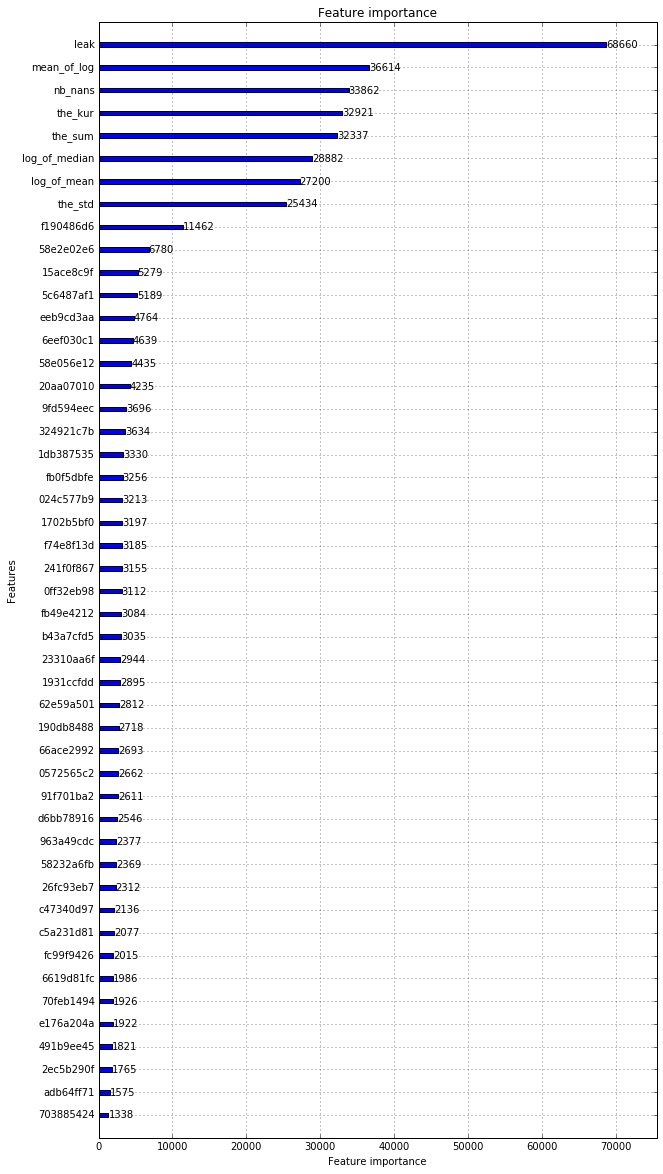

In [172]:
lgb.plot_importance(lgb_clf, figsize=(10,20))
plt.show()

In [173]:
X.columns

Index(['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
       '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
       'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b',
       '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992',
       'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd',
       '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a',
       '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2',
       '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98',
       'log_of_mean', 'mean_of_log', 'log_of_median', 'nb_nans', 'the_sum',
       'the_std', 'the_kur', 'leak'],
      dtype='object')

In [178]:
ID_target = _test['ID']

In [179]:
X_target.columns

Index(['48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00', '2f0771a37',
       '30347e683', 'd08d1fbe3', '6ee66e115', '20aa07010', 'dc5a8f1d8',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4991)

In [180]:
features = transact_cols
_test.replace(0, np.nan, inplace=True)
_test['log_of_mean'] = np.log1p(_test[features].replace(0, np.nan).mean(axis=1))
_test['mean_of_log'] = np.log1p(_test[features]).replace(0, np.nan).mean(axis=1)
_test['log_of_median'] = np.log1p(_test[features].replace(0, np.nan).median(axis=1))
_test['nb_nans'] = _test[features].isnull().sum(axis=1)


NameError: name '_np' is not defined

In [181]:
_test['the_sum'] = np.log1p(_test[features].sum(axis=1))
_test['the_std'] = _test[features].std(axis=1)
_test['the_kur'] = _test[features].kurtosis(axis=1)

# Only use good features, log leak and stats for training

In [183]:
features = cols + [ 'log_of_mean', 'mean_of_log', 'log_of_median', 'nb_nans', 'the_sum', 'the_std', 'the_kur']

In [184]:
X_target  = _test[features ]

In [188]:
X_target['leak'] = _test['compiled_leak']

/home/roosh/Ridero/neural_net_env/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [187]:
X.shape

(4459, 48)

In [202]:
Y_target = lgb_clf.predict(X_target)

In [203]:
np.expm1(Y_target)

array([2091153.43568478, 1585625.95436167, 1430886.15371119, ...,
       1899424.880632  ,  460438.83914753, 3233785.98644582])

In [204]:
sub = _test[['ID']]

In [205]:
sub['target'] = np.expm1(Y_target)
sub.to_csv('sub_lgb_leak_baseline.csv', index=False)

/home/roosh/Ridero/neural_net_env/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [206]:
!head sub_lgb_leak_baseline.csv

ID,target
000137c73,2091153.4356847827
00021489f,1585625.954361666
0004d7953,1430886.15371119
00056a333,4996603.917734638
00056d8eb,1108359.6344346404
0005fc190,2291116.9960869015
000787e86,1975163.5465481132
0008510a0,1752775.40141742
000895faf,6520267.037741122
